### Set up Data and Import Libraries

In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [59]:
#Define df as our Dataset and set date as our index for the Dataset
df = pd.read_csv("data_clean_with_dummies.csv")
df = df.set_index('date')

#Define X and y, with X holding the Features and y the correspoding Count of pedestrians
#Features with PCA k=0.999 (PC1 - PC48)
X = df[df.columns[55:103]]

# The targetvariable we try to predict is the pedestrian count
y = df["pedestrians count"]

In [60]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets as numpy arryas (for our Neural Network)
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)


from sklearn.preprocessing import StandardScaler
#Normalize the Data
# Scale the inputs to standardize the values of the Features
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.fit_transform(Xtest)

### Visualize and exploratory data analysis Data 

In [112]:
df_v = pd.read_csv("data_clean_WITHOUT_dummies.csv") #Load the Dataset without Dummie variables for better visualization
df_v = df_v.drop(labels=range(0,144), axis=0) #Drop the first 144 rows to start with a monday and have better Visualization. The 144 Rows dont matter since we have over 15000
df_v = df_v.set_index('date')

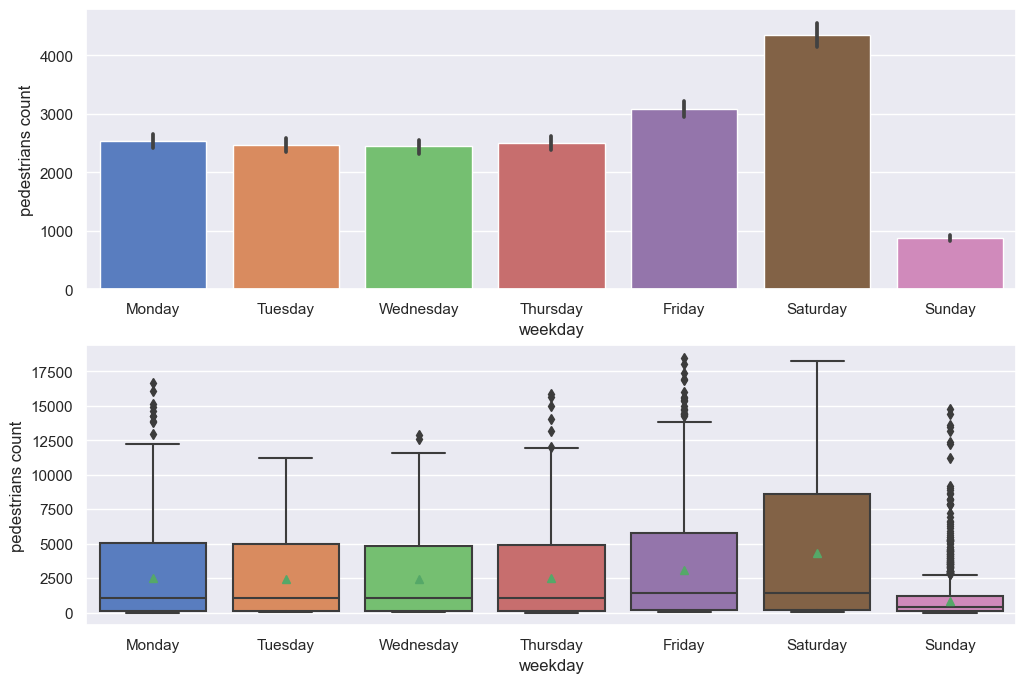

In [62]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, y="pedestrians count", x="weekday", palette="muted", ax=axs[0])
sns.boxplot(data=df_v, y="pedestrians count", x="weekday", palette="muted", ax=axs[1], showmeans=True)

plt.show()

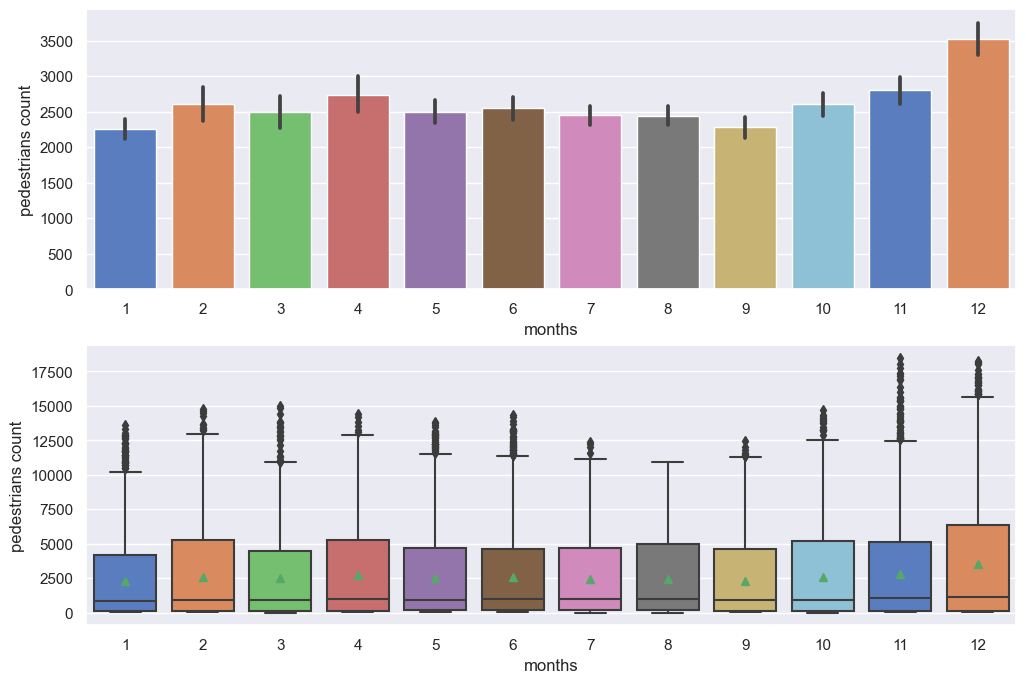

In [63]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, y="pedestrians count", x="months", palette="muted", ax=axs[0])
sns.boxplot(data=df_v, y="pedestrians count", x="months", palette="muted", ax=axs[1], showmeans=True)

plt.show()

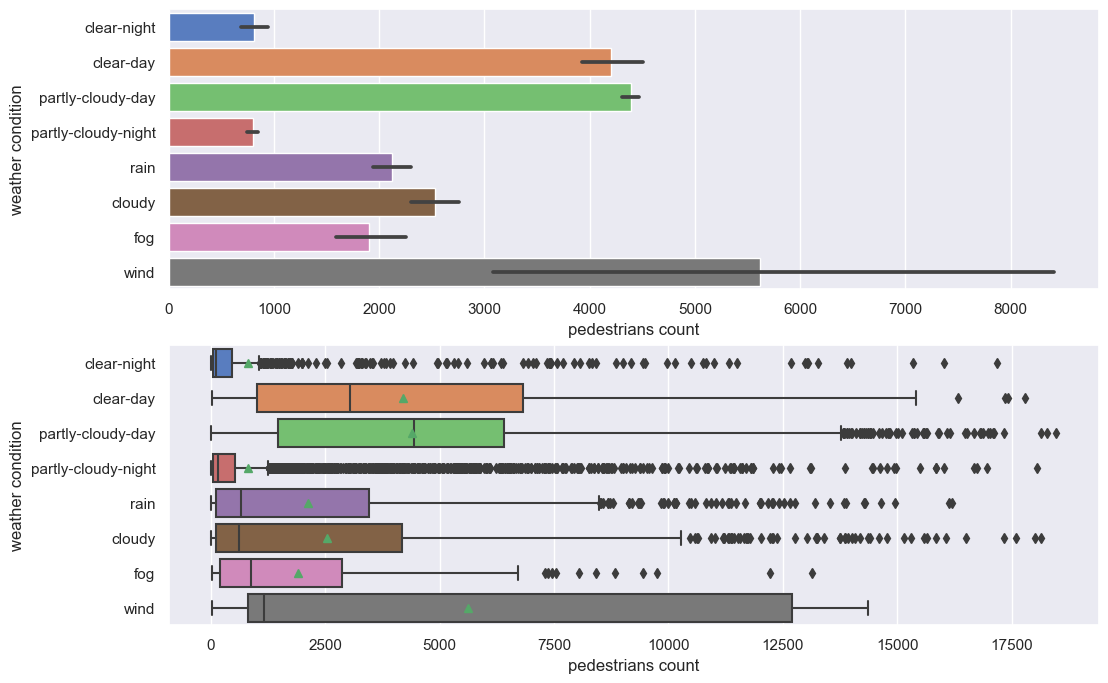

In [64]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, x="pedestrians count", y="weather condition", palette="muted", ax=axs[0]) #Plots Mean
sns.boxplot(data=df_v, x="pedestrians count", y="weather condition", palette="muted", ax=axs[1], showmeans=True) 

plt.show()

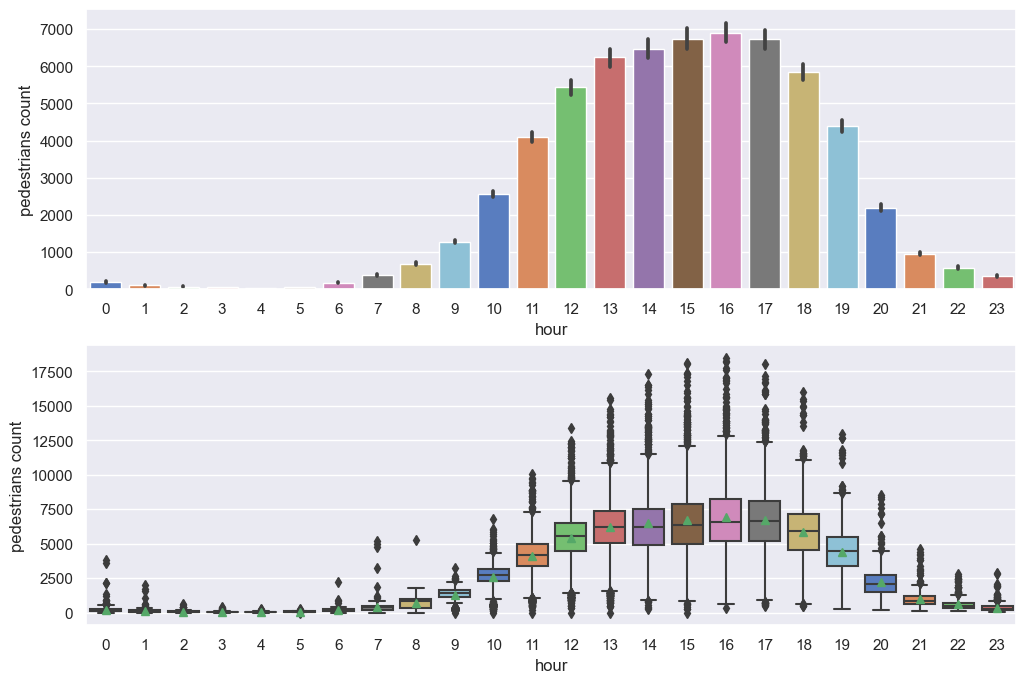

In [65]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, x="hour", y="pedestrians count", palette="muted", ax=axs[0])#Plots Mean
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", ax=axs[1], showmeans=True)
plt.show()

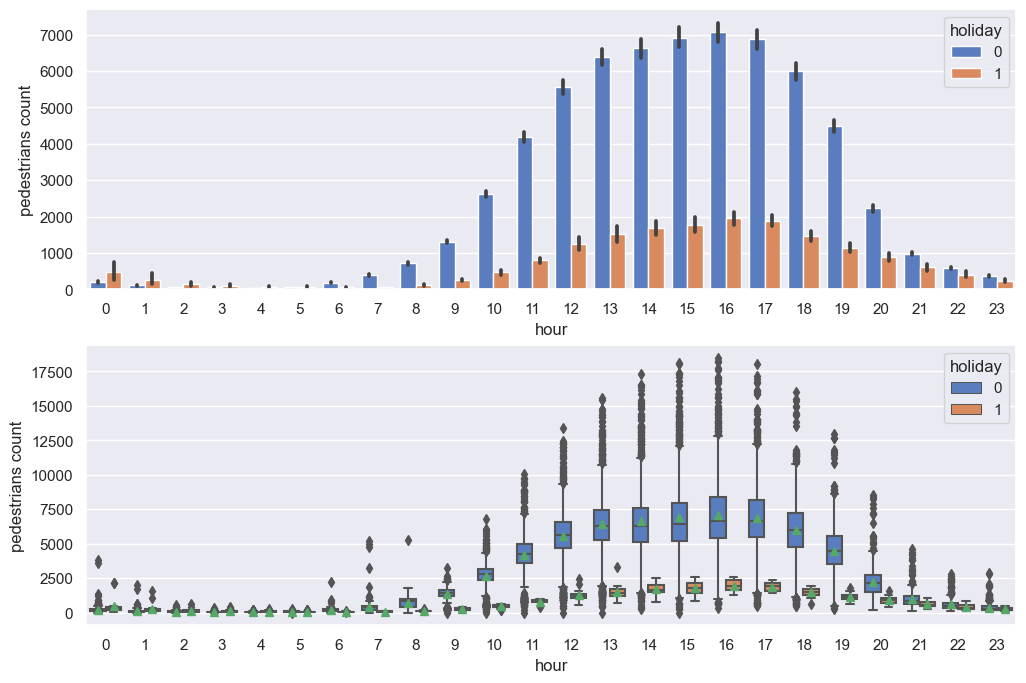

In [66]:
fig, axs = plt.subplots(2, figsize=(12,8))


sns.barplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="holiday", ax=axs[0])
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="holiday", ax=axs[1], showmeans=True)

plt.show()

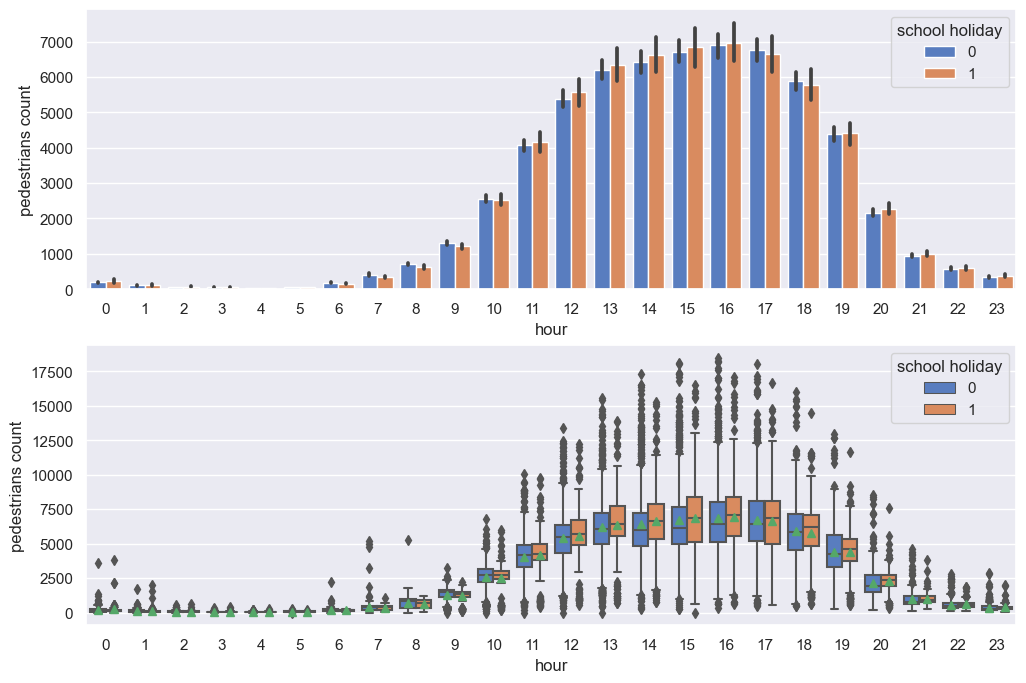

In [67]:
fig, axs = plt.subplots(2, figsize=(12,8))


sns.barplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="school holiday", ax=axs[0])
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="school holiday", ax=axs[1], showmeans=True)

plt.show()

### Define Functions for easier use

In [68]:
def Xtest_smaller(Xtest, ytest, percent=0.5, min_ped=0):
    """
    Give a certain percent or minimum pedestrian condition on the entries in the Test dataset (or the train dataset) 
    to create a smaller Test dataset to do further exploratorive data analysis.

    percent: Percent of the original Dataset you want to keep on a scale between 0 and 1
    min_pred: Minimum number of pedestrians and the corresponding feautes the smaller dataset should keep

    Check to validate it works:
    1:
    Xtest_small, ytest_small = Xtest_smaller(Xtest, ytest, percent=1, min_ped=0)
    np.array_equal(ytest, ytest_small) --> True

    2:
    Xtest_small, ytest_small = Xtest_smaller(Xtest, ytest, percent=0.5, min_ped=0)
    ytest.shape[0] == ytest_small.shape[0] * 2 --> True

    3:
    Xtest_small, ytest_small = Xtest_smaller(Xtest, ytest, percent=1, min_ped=400)
    ytest_small.min() --> 400
    """

    dfXtest = pd.DataFrame(Xtest) #Create a dataframe
    dfytest = pd.DataFrame(ytest) #Create a dataframe 
    
    dfytest.index = range(dfytest.shape[0]) #set the index of the ytest dataframe to numbers from 0 to len of the dataframe 

    new_df = pd.concat([dfytest, dfXtest], axis=1) #Concat the two dataframes to create a new combined one

    if min_ped > 0: #Check if you want to restrict to a minimum number of pedestrians
        if percent == 1: #Check if you want a 100% of the entries with the minimum number of pedestrians 
            new_df_small = new_df.loc[new_df["pedestrians count"] >= min_ped]

            ytest_small = new_df_small["pedestrians count"]
            Xtest_small = new_df_small[new_df_small.columns[1:49]]
        if percent != 1: #Check if you don't want a 100% of the entries
            new_df_small = new_df.loc[new_df["pedestrians count"] >= min_ped]

            df_ytest_small = new_df_small["pedestrians count"]
            df_Xtest_small = new_df_small[new_df_small.columns[1:49]]

            #Split the dataset into two parts with the test_size determined by the percent of entries you want to keep
            Xtrain_small, Xtest_small, ytrain_small, ytest_small  = train_test_split( 
                df_Xtest_small, df_ytest_small, test_size=percent, random_state=72)
    else: #If you only want to split the original dataset into a smaller one on a percentage basis (without a minimum number of pedestrians)
        df_ytest_small = new_df["pedestrians count"]
        df_Xtest_small = new_df[new_df.columns[1:49]]
        
        #Split the dataset into two parts with the test_size determined by the percent of entries you want to keep
        Xtrain_small, Xtest_small, ytrain_small, ytest_small  = train_test_split(
            df_Xtest_small, df_ytest_small, test_size=percent, random_state=72)
    
    if percent == 1 and min_ped==0: #If you dont want a smaller dataset (idk, reduce possible mistakes)
       Xtest_small = dfXtest #So to_numpy() works in the return statement
       ytest_small = ytest


    return Xtest_small.to_numpy(), ytest_small #Turn dataframe to numpy array in order to perfom mathematical operations


In [69]:

from tensorflow import keras
#Define a function two define two callbacks with certain parameters
def def_callbacks(stope_p = 10, reducelr_p=5, reducelr_lr=0.00001): #Use standard values when now argument is give n
    """
    stop_early patience = 10
    reduce_lr patience =5, reducelr learning rate=0.00001)
    """
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=stope_p)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=reducelr_p, min_lr=reducelr_lr)
    callbacks_list = [stop_early,reduce_lr]
    return callbacks_list
    

### Baseline Model with Tensorflow

In [106]:
from tensorflow.keras import layers
from tensorflow import keras

In [128]:
#Define Neural Network model

#Create a Keras Sequential class to hold the different layers of our Neural Network
model = keras.Sequential()

model.add(keras.Input(shape=X.shape[1])) #Add a Input layer and define the Input shape of it (which is the column lenght of the feature Dataset X)
model.add(layers.Dense(100, activation="relu")) #Add a Hidden layer with 500 Neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
model.add(layers.Dense(50, activation="relu")) #Add a second Hidden layer with 250 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 100 Neurones with Dense. 
model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 100 Neurones with Dense. 
model.add(layers.Dense(25, activation="relu")) #Add a fourth Hidden layer with 50 Neurones with Dense. 
model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 50 Neurones with Dense. 
model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 50 Neurones with Dense. 
model.add(layers.Dense(1, activation="relu")) # Add a output layer with 1 Neuron because we only have one output --> predicted pedestrian count

model.summary()#Display an overview of the Model


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 100)               4900      
                                                                 
 dense_22 (Dense)            (None, 50)                5050      
                                                                 
 dense_23 (Dense)            (None, 50)                2550      
                                                                 
 dense_24 (Dense)            (None, 50)                2550      
                                                                 
 dense_25 (Dense)            (None, 25)                1275      
                                                                 
 dense_26 (Dense)            (None, 10)                260       
                                                                 
 dense_27 (Dense)            (None, 10)               

In [129]:

#Specify the training configuration for the Neural Network
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Optimizer that minimizes our loss function (f.e SGD or Adam) with a learning rate of 0.001
    loss=keras.losses.mae,  # Loss function to minimize --> Mean absolute error 
    metrics=["mae", "mse"], # List of metrics to monitor
)


history = model.fit(
    Xtrain, # Fit the model on the train data 
    ytrain, #Fit the model on the train data 
    #batch_size=64, #Dataset will be divided into batches with 64 samples and will be updated after each batch size accordingly
    epochs=100, # 1 epoch is one training iteration - for each epoch the Neural Network processes the entire training data 
    callbacks = def_callbacks(15), #Stop training when training is no longer improving Mean absolute error of the validation data (20% of the training data) within 20 epochs(--> def_callbacks Function)
    validation_split=0.2, #Reserve 20% of the training data for validation at the end of each epoch 
)

Epoch 1/100


2022-11-27 15:24:57.210913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


135/135 [==============================] - ETA: 0s - loss: 2422.3027 - mae: 2422.3027 - mse: 15068968.0000

2022-11-27 15:25:00.600673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


135/135 [==============================] - 5s 22ms/step - loss: 2422.3027 - mae: 2422.3027 - mse: 15068968.0000 - val_loss: 1768.9860 - val_mae: 1768.9860 - val_mse: 7194351.5000 - lr: 0.0010
Epoch 2/100
135/135 [==============================] - 2s 13ms/step - loss: 1085.9243 - mae: 1085.9243 - mse: 3250293.2500 - val_loss: 751.2423 - val_mae: 751.2423 - val_mse: 1823704.0000 - lr: 0.0010
Epoch 3/100
135/135 [==============================] - 2s 11ms/step - loss: 712.3447 - mae: 712.3447 - mse: 1762001.0000 - val_loss: 601.9341 - val_mae: 601.9341 - val_mse: 1381383.5000 - lr: 0.0010
Epoch 4/100
135/135 [==============================] - 2s 11ms/step - loss: 580.5591 - mae: 580.5591 - mse: 1350298.7500 - val_loss: 508.8707 - val_mae: 508.8707 - val_mse: 1088163.2500 - lr: 0.0010
Epoch 5/100
135/135 [==============================] - 1s 11ms/step - loss: 497.4426 - mae: 497.4426 - mse: 1097211.8750 - val_loss: 452.8670 - val_mae: 452.8670 - val_mse: 937934.5000 - lr: 0.0010
Epoch 6/100

### Model evaluation

In [130]:
# Evaluate the model on the test data using `evaluate` result is the corresponding MAE
print("Evaluate on test data")
results = model.evaluate(Xtest, ytest)
results_train = model.evaluate(Xtrain, ytrain)
print("test loss, test mae, test mse:", results)
print("train loss, train mae, train mse:", results_train)

Evaluate on test data
336/336 [==============================] - 2s 6ms/step - loss: 283.2901 - mae: 283.2901 - mse: 590024.1250
test loss, test mae, test mse: [322.0931701660156, 322.0931701660156, 526132.0625]
train loss, train mae, train mse: [283.29010009765625, 283.29010009765625, 590024.125]


In [131]:
#Create a function that evaluates the model and saves the results in a dataframe for comparisson
def evaluate_model(model, Xtest, ytest):
    eval_dict = model.evaluate(Xtest, ytest, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df

# Evaluate basemodel on test set and add results to dataframe
results_comparisson = evaluate_model(model, Xtest, ytest)

# Set index to 'Baseline'
results_comparisson.index = ['Startwerte']

# Display results
results_comparisson.head()

144/144 [==============================] - 1s 7ms/step - loss: 322.0932 - mae: 322.0932 - mse: 526132.0625


,loss,mae,mse
Startwerte,322.09317,322.09317,526132.0625


### Visualize the Model performance

2022-11-27 15:27:30.922120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 5ms/step


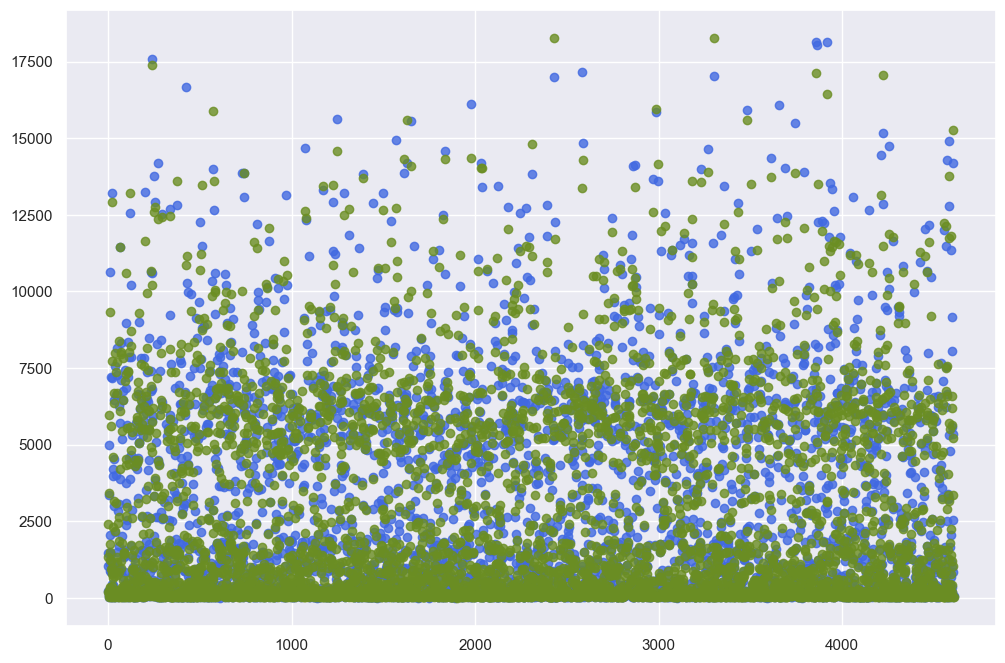

In [132]:
#Visualize the results predictions vs actual values
#Create a sequenze from 0 to the row lenght of the test data in order to plot
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual values
ypred = model.predict(Xtest)


fig, ax = plt.subplots(figsize=(12, 8))

plt.scatter(xs, ytest, color ='royalblue', alpha=0.8)

plt.scatter(xs, ypred, color ='olivedrab', alpha=0.8)

plt.show()

144/144 [==============================] - 1s 9ms/step - loss: 322.0932 - mae: 322.0932 - mse: 526132.0625


Text(109.87499999999999, 0.5, 'MAE')

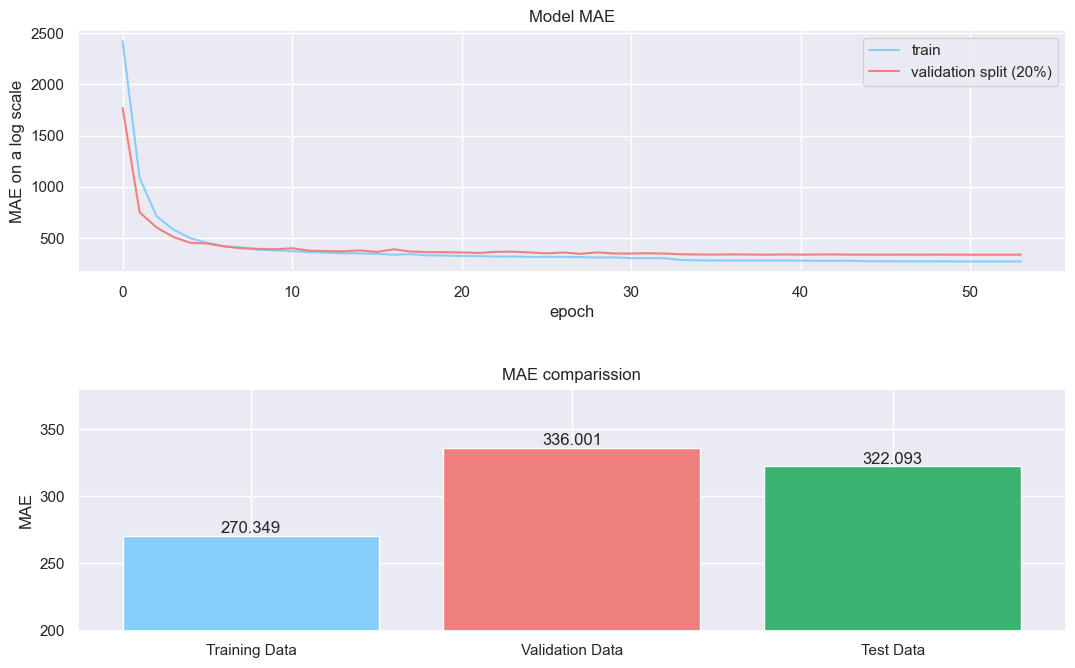

In [133]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(2, figsize=(12, 8))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['mae'], label="train", color="lightskyblue")
axs[0].plot(history.history['val_mae'], label="validation split (20%)", color="lightcoral")
axs[0].set_title('Model MAE')
axs[0].set_ylabel('MAE on a log scale')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')
#axs[0].set_yscale("log")

f_mae = history.history["mae"]
f_val_mae = history.history["val_mae"]
f_test_mae = model.evaluate(Xtest, ytest)

axs[1].bar("Training Data",min(f_mae), color="lightskyblue") #Display minimum mae of the training data set
axs[1].bar("Validation Data", min(f_val_mae), color="lightcoral")#Display minimum mae of the validation data set
axs[1].bar("Test Data", f_test_mae[0], color="mediumseagreen")#Display mae of the test data set
axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')
axs[1].set_ylim([200, 380])
axs[1].set_title('MAE comparission')
axs[1].set_ylabel('MAE')


144/144 [==============================] - 1s 7ms/step - loss: 322.0932 - mae: 322.0932 - mse: 526132.0625


([<matplotlib.axis.XTick at 0x4e03b6bf0>,
 [Text(0.2, 0, 'Training Data'),
  Text(1.2, 0, 'Validation Data'),
  Text(2.2, 0, 'Test Data')])

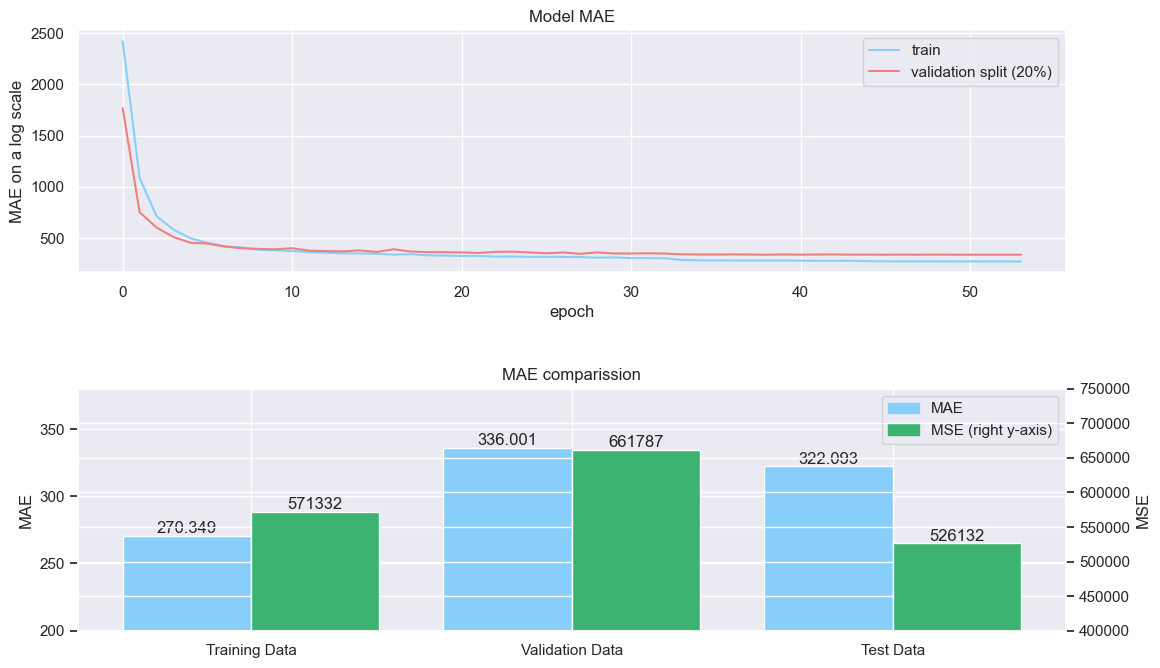

In [134]:
import matplotlib.patches as mpatches

#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(2, figsize=(12, 8))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['mae'], label="train", color="lightskyblue")
axs[0].plot(history.history['val_mae'], label="validation split (20%)", color="lightcoral")
axs[0].set_title('Model MAE')
axs[0].set_ylabel('MAE on a log scale')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')
#axs[0].set_yscale("log")

f_mae = history.history["mae"]
f_val_mae = history.history["val_mae"]
f_test_mae = model.evaluate(Xtest, ytest)


axs4 = axs[1].twinx()

x_axis = np.arange(3)

nameofdata = ["Training Data","Validation Data","Test Data"]

f_mse = history.history["mse"]
f_val_mse = history.history["val_mse"]


axs[1].bar(x_axis[0],min(f_mae), color="lightskyblue", width=0.4) #Display minimum mae of the training data set
axs[1].bar(x_axis[1], min(f_val_mae), color="lightskyblue", width=0.4)#Display minimum mae of the validation data set
axs[1].bar(x_axis[2], f_test_mae[0], color="lightskyblue", width=0.4)#Display mae of the test data set

axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')

axs[1].set_ylim([200, 380])
axs[1].set_title('MAE comparission')
axs[1].set_ylabel('MAE')


axs4.bar(x_axis[0] +0.4, min(f_mse), color="mediumseagreen", width=0.4)
axs4.bar(x_axis[1]+0.4, min(f_val_mse), color="mediumseagreen", width=0.4,)
axs4.bar(x_axis[2]+0.4, f_test_mae[2], color="mediumseagreen", width=0.4,)
axs4.set_ylabel('MSE')

axs4.bar_label(axs4.containers[0], label_type='edge')
axs4.bar_label(axs4.containers[1], label_type='edge')
axs4.bar_label(axs4.containers[2], label_type='edge')
axs4.set_ylim([400000, 750000])




#Custom Legend
leg_mae = mpatches.Patch(color='lightskyblue', label='MAE')
leg_mse = mpatches.Patch(color='mediumseagreen', label='MSE (right y-axis)')

axs[1].legend(handles=[leg_mae, leg_mse])

plt.xticks(x_axis + 0.2,nameofdata)

### Hyperparamter tuning 

In [78]:
import keras_tuner as kt

In [79]:
# def model_builder(hp): LEARNING RATE DECREASE implementieren
 
#     # Initialize sequential API and start building model.
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten())
    
#     # Tune the number of hidden layers and units in each aswell as the best activation function.
#     # Number of hidden layers: 1 - 8
#     # Number of Units: 32 - 512 with stepsize of 32
#     for i in range(1, hp.Int("num_layers", 2, 7)):
        
#         hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
        
#         model.add(
#             keras.layers.Dense(
#                 units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
#                 activation=hp_activation)
#             )
        
      
#     # Add output layer.
#     model.add(keras.layers.Dense(units=1, activation="relu"))
    
#     # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
#     # Define optimizer, loss, and metrics
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss=keras.losses.mae,
#                   metrics=["mae"])
    
#     return model


#### Tuning Optimzer, learning rate and activation function
##### This approach is used to reduce the computing time. A better way would be to build a larger model where the tuner would tune the optimizer, number of layers and number on nodes at the same time

In [80]:
#Find the best Optimizer on the baseline model 
def model_builder(hp): 
 
# Initialize sequential API and start building model.   
    model = keras.Sequential()

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])    

    model.add(keras.layers.Flatten()) #Add a Input layer and use flatten to get a 1 dimensional input!!!!
    model.add(layers.Dense(100, activation=hp_activation)) #Add a Hidden layer with 500 Neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
    model.add(layers.Dense(50, activation=hp_activation)) #Add a second Hidden layer with 250 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
    model.add(layers.Dense(50, activation=hp_activation)) #Add a third Hidden layer with 100 Neurones with Dense. 
    model.add(layers.Dense(50, activation=hp_activation)) #Add a third Hidden layer with 100 Neurones with Dense. 
    model.add(layers.Dense(25, activation=hp_activation)) #Add a fourth Hidden layer with 50 Neurones with Dense. 
    model.add(layers.Dense(10, activation=hp_activation)) #Add a fourth Hidden layer with 50 Neurones with Dense. 
    model.add(layers.Dense(1, activation=hp_activation))  #Add an output layer with activation function relu  

    #Tune learning rate 
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])  # Tune learning rate with values 0.01, 0.001, 0.0001, 0.00001

    optimizers_dict = {
        "Adam":    keras.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     keras.optimizers.SGD(learning_rate=hp_learning_rate),
        "Adagrad": keras.optimizers.Adagrad(learning_rate=hp_learning_rate),
        "Adadelta": keras.optimizers.Adadelta(learning_rate=hp_learning_rate),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
        }

    hp_optimizers = hp.Choice(
        'optimizer', 
        values=["Adam", "SGD", "Adagrad", "Adadelta", "RMSprop"]
        )


    model.compile(optimizer=optimizers_dict[hp_optimizers],
                  loss=keras.losses.mae,
                  metrics=["mae"])
    
    return model

In [81]:
#Easy tuner because we only have 5 different Optimizer options, 4 learning rate optimizations and 2 activation functions, so randomly selecting is okay because no matter what we will try every combination of the 40
tuner = kt.RandomSearch(hypermodel = model_builder,
                       objective = 'val_mae',
                       max_trials = 10,
                       executions_per_trial = 1,
                       directory = 'kt_dir',
                       overwrite=True,
                       project_name = 'kt_RandomSearch')

In [82]:
tuner.search(Xtrain, ytrain, epochs=10, validation_split=0.2, callbacks=def_callbacks(reducelr_lr=0.000001))

Trial 10 Complete [00h 16m 52s]
val_mae: 995.412353515625

Best val_mae So Far: 359.32000732421875
Total elapsed time: 00h 35m 01s
INFO:tensorflow:Oracle triggered exit


In [83]:
tuner.results_summary() #The best model used the RMSprop Optimizer 

Results summary
Results in kt_dir/kt_RandomSearch
Showing 10 best trials
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: Adam
Score: 359.32000732421875
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: Adadelta
Score: 395.3101806640625
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: Adagrad
Score: 407.686767578125
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.0001
optimizer: RMSprop
Score: 995.412353515625
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: SGD
Score: 2580.465087890625
Trial summary
Hyperparameters:
activation: tanh
learning_rate: 0.001
optimizer: RMSprop
Score: 2604.59716796875
Trial summary
Hyperparameters:
activation: tanh
learning_rate: 0.01
optimizer: Adagrad
Score: 2604.597412109375
Trial summary
Hyperparameters:
activation: tanh
learning_rate: 0.0001
optimizer: Adam
Score: 2604.5986328125
Trial summary
Hyperparameters:
activati

In [150]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#Hypertuned Model 
h1_model = tuner.hypermodel.build(best_hps)
#Create a new Hypertuned History to compare it with the Baseline Histroy 
h1_history = h1_model.fit(Xtrain, ytrain, epochs=100, validation_split=0.2,
                    callbacks=def_callbacks(reducelr_lr=0.000001))


Epoch 1/100


2022-11-27 15:39:08.298355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 877.6008 - mae: 877.6008

2022-11-27 15:39:13.553433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 7s 20ms/step - loss: 877.6008 - mae: 877.6008 - val_loss: 494.0212 - val_mae: 494.0212 - lr: 0.0100
Epoch 2/100
269/269 [==============================] - 3s 11ms/step - loss: 559.1272 - mae: 559.1272 - val_loss: 470.9170 - val_mae: 470.9170 - lr: 0.0100
Epoch 3/100
269/269 [==============================] - 3s 11ms/step - loss: 475.4649 - mae: 475.4649 - val_loss: 631.7614 - val_mae: 631.7614 - lr: 0.0100
Epoch 4/100
269/269 [==============================] - 3s 12ms/step - loss: 483.2540 - mae: 483.2540 - val_loss: 467.8464 - val_mae: 467.8464 - lr: 0.0100
Epoch 5/100
269/269 [==============================] - 3s 10ms/step - loss: 435.8541 - mae: 435.8541 - val_loss: 416.5802 - val_mae: 416.5802 - lr: 0.0100
Epoch 6/100
269/269 [==============================] - 3s 10ms/step - loss: 414.9610 - mae: 414.9610 - val_loss: 373.4629 - val_mae: 373.4629 - lr: 0.0100
Epoch 7/100
269/269 [==============================] - 3s 10ms/step - loss: 404.65

In [151]:
# Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
hyper_results1 = evaluate_model(h1_model, Xtest, ytest) 

# Set index to hypertuned
hyper_results1.index = ["Baseline model Op/lr/af"]

# Append results in dataframe
results_comparisson = pd.concat([results_comparisson, hyper_results1])

results_comparisson.head()


144/144 [==============================] - 1s 6ms/step - loss: 291.5646 - mae: 291.5646


,loss,mae,mse
Startwerte,322.093170,322.093170,526132.0625
Baseline model Op/lr/af,297.609283,297.609283,NaN
Baseline model Op/lr/af,294.290344,294.290344,NaN
Baseline model Op/lr/af,2591.601807,2591.601807,NaN
Baseline model Op/lr/af,299.056305,299.056305,NaN


#### Optimal number of layers and nodes

In [152]:
def model_builder(hp): 
 
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    
    # Tune the number of hidden layers and units in each aswell as the best activation function.
    # Number of hidden layers: 8 - 12
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 6, 8)):

       #Find the bets activation function 
       #hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
        
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=64, max_value=128, step=32), ###!!!!!!! max value auf 512 und min auf 32!!!!! # Find the best number of units (Nodes) betwenn 32 and 512 in 32 steps
                activation="relu")
            )
        
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    # Add output layer.
    model.add(keras.layers.Dense(units=1, activation="relu"))
    
    #Here setting a learning rate is better/more efficient because other wise the Tuner would also have to tune the learning rate adding a huge amout of new models to try 
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss=keras.losses.mae,
                  metrics=["mae"])
    
    return model

In [153]:
# Using the advanced Hyperband tuner which selects different Hyperparameter combinations when the have promising results after a few epochs and tunes them further
tuner = kt.Hyperband(model_builder,
                     objective='val_mae',
                     max_epochs=15, #######!!!!!!
                     factor=3,
                     hyperband_iterations=2, #######!!!!
                     overwrite=True,
                     directory='kt_dir',
                     project_name='kt_hyperband')


In [154]:
# Execute the tuner  
tuner.search(Xtrain, ytrain, epochs=15, validation_split=0.2, callbacks=def_callbacks())

Trial 60 Complete [00h 00m 40s]
val_mae: 339.3460388183594

Best val_mae So Far: 339.3460388183594
Total elapsed time: 00h 24m 26s
INFO:tensorflow:Oracle triggered exit


In [155]:
tuner.results_summary()

Results summary
Results in kt_dir/kt_hyperband
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 6
units_1: 128
units_2: 96
units_3: 128
units_4: 96
units_5: 128
dropout: False
units_6: 96
units_7: 96
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 339.3460388183594
Trial summary
Hyperparameters:
num_layers: 7
units_1: 96
units_2: 64
units_3: 96
units_4: 128
units_5: 96
dropout: True
units_6: 128
units_7: 128
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 342.642578125
Trial summary
Hyperparameters:
num_layers: 7
units_1: 96
units_2: 128
units_3: 96
units_4: 96
units_5: 64
dropout: True
units_6: 64
units_7: 96
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 344.8874816894531
Trial summary
Hyperparameters:
num_layers: 8
units_1: 128
units_2: 128
units_3: 96
units_4: 96
units_5: 96
dropout: True
units_6: 96
units_7: 96
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tune

In [117]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Use the best Hyperparameter to build a new model and train the model on the training Dataset

#Hypertuned Model 
h2_model = tuner.hypermodel.build(best_hps)
#Create a new Hypertuned History to compare it with the Baseline Histroy 
h2_history = h2_model.fit(Xtrain, ytrain, epochs=150, validation_split=0.2,
                    callbacks=def_callbacks(reducelr_lr=0.000001))

Epoch 1/150


2022-11-27 15:10:59.856645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 902.2070 - mae: 902.2070

2022-11-27 15:11:03.732431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 5s 14ms/step - loss: 902.2070 - mae: 902.2070 - val_loss: 980.4377 - val_mae: 980.4377 - lr: 0.0100
Epoch 2/150
269/269 [==============================] - 3s 10ms/step - loss: 601.0416 - mae: 601.0416 - val_loss: 453.4639 - val_mae: 453.4639 - lr: 0.0100
Epoch 3/150
269/269 [==============================] - 2s 9ms/step - loss: 464.9640 - mae: 464.9640 - val_loss: 434.8510 - val_mae: 434.8510 - lr: 0.0100
Epoch 4/150
269/269 [==============================] - 3s 9ms/step - loss: 450.8603 - mae: 450.8603 - val_loss: 458.7997 - val_mae: 458.7997 - lr: 0.0100
Epoch 5/150
269/269 [==============================] - 2s 9ms/step - loss: 430.0834 - mae: 430.0834 - val_loss: 393.7532 - val_mae: 393.7532 - lr: 0.0100
Epoch 6/150
269/269 [==============================] - 3s 9ms/step - loss: 432.0655 - mae: 432.0655 - val_loss: 391.4006 - val_mae: 391.4006 - lr: 0.0100
Epoch 7/150
269/269 [==============================] - 2s 9ms/step - loss: 400.9340 - 

In [118]:
# Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
hyper_results2 = evaluate_model(h2_model, Xtest, ytest)

# Set index to hypertuned
hyper_results2.index = ["Baseline model Op/lr/af and NL/NN"]

# Append results in dataframe
results_comparisson = pd.concat([results_comparisson, hyper_results2])

results_comparisson.head()



144/144 [==============================] - 1s 4ms/step - loss: 291.5910 - mae: 291.5910


,loss,mae,mse
Startwerte,298.133972,298.133972,481778.9375
Baseline model Op/lr/af,295.495514,295.495514,NaN
Baseline model Op/lr/af and NL/NN,307.885712,307.885712,NaN
Baseline model Op/lr/af and NL/NN,291.590973,291.590973,NaN


### Complete Optimizer Model

In [92]:
# def model_builder(hp): 
 
#     # Initialize sequential API and start building model.
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten())
    
#     # Tune the number of hidden layers and units in each aswell as the best activation function.
#     # Number of hidden layers: 6 - 12
#     # Number of Units: 32 - 512 with stepsize of 32
#     for i in range(1, hp.Int("num_layers", 6, 12)):

#        #Find the bets activation function 
#        hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
        
#         model.add(
#             keras.layers.Dense(
#                 units=hp.Int("units", min_value=32, max_value=512, step=32), # Find the best number of units (Nodes) betwenn 32 and 512 in 32 steps
#                 activation=hp_activation)
#             )
        
      
#     # Add output layer.
#     model.add(keras.layers.Dense(units=1, activation="relu"))


#     #Tune learning rate

#     #hp_learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log") ##very time consuming
   
#     hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])  # Tune learning rate with values 0.01, 0.001, 0.0001, 0.00001
    
#     #Tune optimal optimizer 

#     optimizers_dict = {
#         "Adam":    keras.optimizers.Adam(learning_rate=hp_learning_rate),
#         "SGD":     keras.optimizers.SGD(learning_rate=hp_learning_rate),
#         "Adagrad": keras.optimizers.Adagrad(learning_rate=hp_learning_rate),
#         "Adadelta": keras.optimizers.Adadelta(learning_rate=hp_learning_rate),
#         "RMSprop": keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
#         }

#     hp_optimizers = hp.Choice(
#         'optimizer', 
#         values=["Adam", "SGD", "Adagrad", "Adadelta", "RMSprop"]
#         )


#     # Define optimizer, loss, and metrics
#     model.compile(optimizer= optimizers_dict[hp_optimizers],
#                   loss=keras.losses.mae,
#                   metrics=["mae"])
    
#     return model

In [93]:
# # Create a tuner 
# tuner = kt.Hyperband(model_builder,
#                      objective='val_mae',
#                      max_epochs=25,
#                      factor=3,
#                      hyperband_iterations=15,
#                      overwrite=True,
#                      directory='kt_dir',
#                      project_name='kt_hyperband')


In [94]:
# Execute the tuner  
# tuner.search(Xtrain, ytrain, epochs=25, validation_split=0.2, callbacks=def_callbacks())

In [95]:
# tuner.results_summary()

### Further Hypertuning

In [96]:
# Save the best Hyperparameter the tuner has found 
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [97]:
# #Hypertuned Model 
# h3_model = tuner.hypermodel.build(best_hps)
# #Create a new Hypertuned History to compare it with the Baseline Histroy 
# h3_history = h3_model.fit(Xtrain, ytrain, epochs=500, validation_split=0.2,
#                     callbacks=def_callbacks(stope_p=25, reducelr_lr=0.000001))


In [98]:
# # Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
# hyper_results3 = evaluate_model(h3_model, Xtest, ytest)

# # Set index to hypertuned
# hyper_results3.index = ["Model with Hyperparametern tuned 'further'"]

# # Append results in dataframe
# results_comparisson = pd.concat([results_comparisson, hyper_results3])

# results_comparisson.head()



In [99]:
# h3_model.summary()#Display an overview of the Model

### Evaluate and Viusalize the Hypertuned Model 

In [100]:
# # Evaluate the model on the test data using `evaluate` result is the corresponding MAE
# print("Evaluate on test data")
# h3_results = h3_model.evaluate(Xtest, ytest)
# h3_results_train = h3_model.evaluate(Xtrain, ytrain)
# print("HP!! test loss, test mae, test mse:", h3_results)
# print(" HP!!!! train loss, train mae, train mse:", h3_results_train)

2022-11-27 15:14:26.717111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 4ms/step


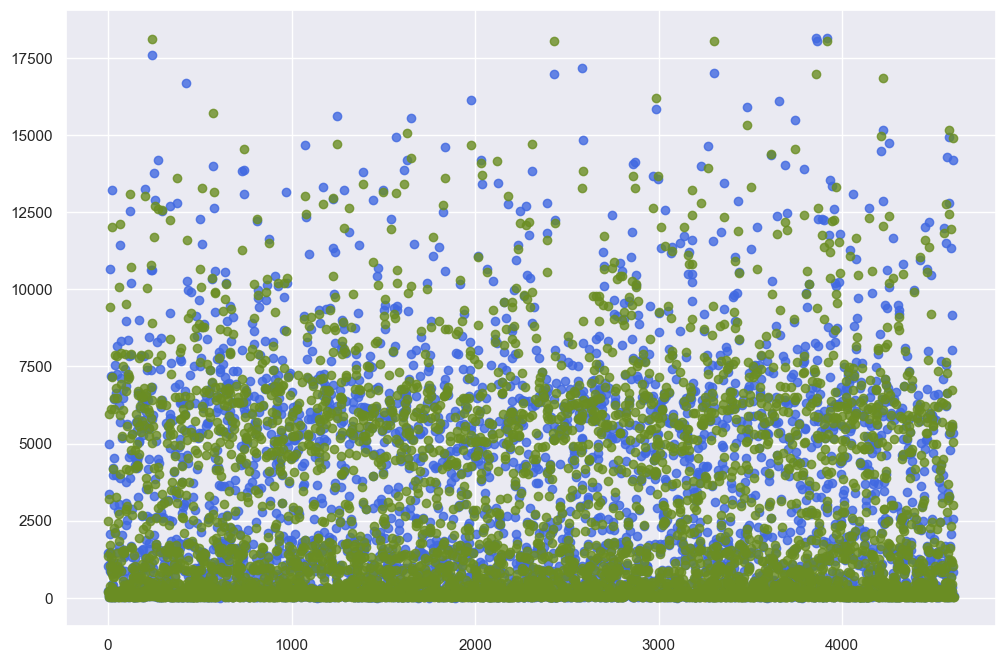

In [119]:
#Visualize the results predictions vs actual values
#Create a sequenze from 0 to the row lenght of the test data in order to plot
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual values
#yhpred = h3_model.predict(Xtest)
yhpred = h2_model.predict(Xtest) ###Just for this night to get results 

fig, ax = plt.subplots(figsize=(12, 8))

plt.scatter(xs, ytest, color ='royalblue', alpha=0.8)

plt.scatter(xs, yhpred, color ='olivedrab', alpha=0.8)

plt.show()

2022-11-27 15:14:32.288781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 7ms/step - loss: 2348.5591 - mae: 2348.5591 - mse: 13530885.0000


2022-11-27 15:14:33.771300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 4ms/step - loss: 291.5910 - mae: 291.5910


Text(109.87499999999999, 0.5, 'MAE')

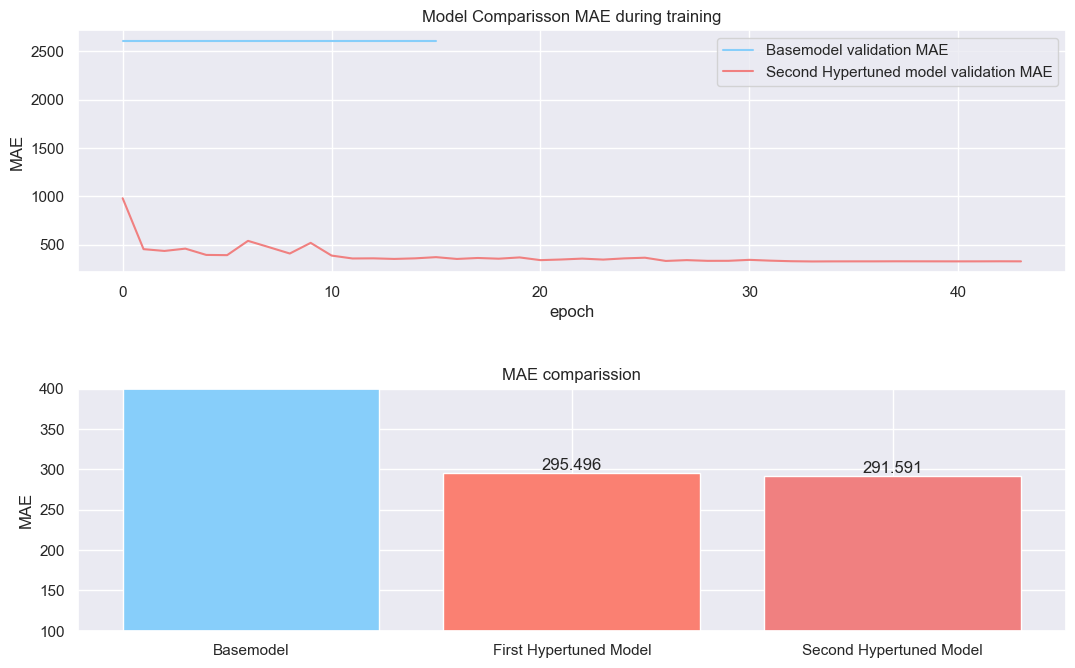

In [120]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(2, figsize=(12, 8))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['val_mae'], label="Basemodel validation MAE", color="lightskyblue")
#axs[0].plot(h1_history.history['val_mae'], label="First Hypertuned model validation MAE", color="salmon")
axs[0].plot(h2_history.history['val_mae'], label="Second Hypertuned model validation MAE", color="lightcoral")
#axs[0].plot(h3_history.history['val_mae'], label="Complet Hypertuned model validation MAE", color="navy")
axs[0].set_title('Model Comparisson MAE during training')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')


base_mae = model.evaluate(Xtest, ytest)
hp1_mae = h1_model.evaluate(Xtest, ytest)
hp2_mae = h2_model.evaluate(Xtest, ytest)
#hp3_mae = h3_mode.evaluate(Xtest, ytest)


axs[1].bar("Basemodel", base_mae[0], color="lightskyblue" )
axs[1].bar("First Hypertuned Model", hp1_mae[0], color="salmon")
axs[1].bar("Second Hypertuned Model", hp2_mae[0], color="lightcoral")
#axs[1].bar("Complet Hypertuned Model", hp3_mae[0], color="navy")


axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')
#axs[1].bar_label(axs[1].containers[3], label_type='edge')
axs[1].set_ylim([100, 400])
axs[1].set_title('MAE comparission')
axs[1].set_ylabel('MAE')